In [1]:
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger

from keyrover import *
from keyrover.vision import *
from keyrover.datasets import KeyboardCornersDataset
from keyrover.math.bilinear import InterpolateQuad

import wandb

wandb.login()
device

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


'mps'

In [2]:
SIZE = (256, 256)

train_dataset, valid_dataset, test_dataset = KeyboardCornersDataset.load("v4-nodistort", size=SIZE)
len(train_dataset), len(valid_dataset), len(test_dataset)

100%|██████████| 500/500 [00:00<00:00, 667.34it/s]


(4000, 499, 500)

<class 'torch.Tensor'> (torch.float32, shape=torch.Size([3, 256, 256]))
        Min: -1.32241952419281
        Max: 2.067323684692383
        Mean: -0.417470246553421


tensor([[ 84.2610, 426.1557, 781.9355, 345.4391, 741.5093,  88.9565,  69.7198,
         158.5822]])

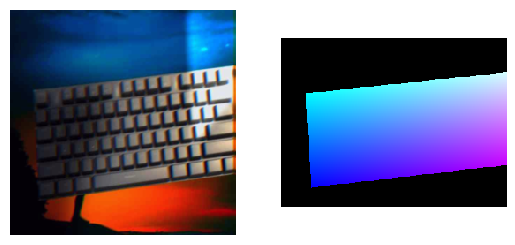

In [6]:
train_dataset.set_transforms([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
])

train_dataset.set_input_augmentations([
    # transforms.GaussianNoise(sigma=0.1, clip=True),
    # transforms.RandomApply([transforms.GaussianNoise(sigma=0.1, clip=False)], p=0.5),
], norm_params="default")

transform = InterpolateQuad(1, width=640, height=480, device=device)

img, corners = train_dataset.random_img()
corners = train_dataset.denormalize(corners)
mask = transform(corners)[0]

imshow(img, mask)
describe(img)

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(train_dataset, valid_dataset, test_dataset,
                                                                         batch_size=64, num_workers=2,
                                                                         persistent_workers=True, pin_memory=True)
corners

In [ ]:
from torchvision import models


class CornersRegressionModel(KeyboardModel):
    def __init__(self, lr: float | None = None) -> None:
        super().__init__()

        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(self.model.fc.in_features, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
        )

        self.loss_fn = torch.nn.MSELoss()

        self.lr = lr
        self.save_hyperparameters()

    def predict(self, image: torch.Tensor, mask: bool = True) -> np.ndarray:
        image = image.to(self.device)
        if len(image.shape) == 3:
            image = image.unsqueeze(0)

        with torch.no_grad():
            pred = self.forward(image, mask=mask).cpu().numpy()

        if len(pred) == 1:
            return pred[0,]
        return pred

    def forward(self, image: torch.Tensor, mask: bool = True) -> torch.Tensor:
        return self.model(image)

    def _step(self, batch: tuple[torch.Tensor, torch.Tensor], stage: str) -> float:
        image, target = batch
        predictions = self(image)

        loss = self.loss_fn(predictions, target)
        self.log(f"{stage}_loss", loss)
        return loss

In [ ]:
LEARNING_RATE = 4e-4

wandb.finish()
model = CornersRegressionModel(lr=LEARNING_RATE)
model

In [ ]:
summarize(model)

In [ ]:
logger = WandbLogger(project="mrover-keyboard-corner-prediction")

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(log_every_n_steps=1, logger=logger, max_time="00:08:00:00", callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

In [ ]:
model.save(f"models/corner-prediction/{wandb.run.name}.pt")

In [ ]:
model.to(device)
model.eval()

img, corners = valid_dataset.random_img()
img = img.unsqueeze(0).to(device)

pred = model(img) * std + mean
pred = tuple(*pred.reshape((1, 4, 2, 1)))
pred = corners_to_texture_coordinates(pred)

corners = torch.tensor(corners, device=device) * std + mean
corners = tuple(*corners.reshape((1, 4, 2, 1)))
mask = corners_to_texture_coordinates(corners)

imshow(img[0], mask[0])
imshow(img[0], pred[0])

In [ ]:
img = cv2.imread(f"{TEST_DATASET}/2-new.jpg")

img = test_transforms(img)
img = img.unsqueeze(0).to(device)

pred = model(img) * std + mean
pred = tuple(*pred.reshape((1, 4, 2, 1)))
pred = corners_to_texture_coordinates(pred)

img = img[0].cpu().numpy()
img = reorder_image_axes(img)
img = cv2.resize(img, (640, 480))
imshow(img, pred[0])